<a href="https://colab.research.google.com/github/Inglam/EECS442/blob/master/Enpei_EECS_442_PS3_ML_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EECS 442 PS3: Learning

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Enpei Zhao, zepxyz

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.






## Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [184]:
import pickle
import matplotlib.pyplot as plt
import random
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from six.moves import cPickle as pickle
import numpy as np
import os
import time
import platform
import csv
from random import randrange
random.seed(0)
np.random.seed(0)
download = not os.path.isdir('cifar-10-batches-py')
dset_train = CIFAR10(root='.', download=download, train='True')
dset_test = CIFAR10(root='.', train='False')

Helper functions for data loading and gradient checking

In [185]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

## Load and visualize CIFAR-10

In [186]:
cifar10_dir = './cifar-10-batches-py'

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Visualize some examples from the dataset.

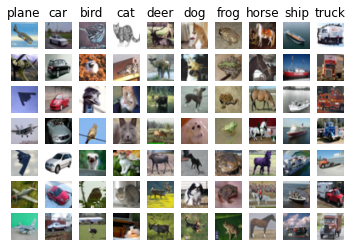

In [187]:
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 7

def visualize_data(dataset, classes, samples_per_class):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
      idxs = np.flatnonzero(y_train == y)
      idxs = np.random.choice(idxs, samples_per_class, replace=False)
      for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((32, 32, 3)).astype('uint8'))
        plt.axis('off')
        if i == 0:
          plt.title(cls)
    plt.show()

visualize_data(X_train, classes, samples_per_class)


## **Problem 3.1**

### (a) Define the KNearestNeighbor class

In [188]:
from collections import Counter
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.
    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.
    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):

        # ===== your code here! =====

        # TODO:                                                             
        # Compute the l2 distance between the ith test image and the jth    
        # training image, and store the result in dists[i, j].              
        dists[i, j] = np.sqrt(np.sum((X[i] - self.X_train[j])**2))
        # ==== end of code ====

    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      
      # ===== your code here! =====
      
      # TODO:                                                               
      # Compute the l2 distance between the ith test point and all training 
      # points, and store the result in dists[i, :].                     
      dists[i,:] = np.sqrt(np.sum((X[i] - self.X_train)**2, axis = 1))
      # ==== end of code ====

    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    
    # ===== your code here! =====
    
    # TODO:                                                                 
    # Compute the l2 distance between all test points and all training      
    # points without using any explicit loops, and store the result in      
    # dists.                                                                
    #                                                                       
    # You should implement this function using only basic array operations; 
    # in particular you should not use functions from scipy.                
    #                                                                       
    # HINT: Try to formulate the l2 distance using matrix multiplication    
    #       and two broadcast sums.
    # Further HINT: Try to think of the expansion of (a-b)^2.  
    a = np.sum(X**2, axis=1)
    b = np.sum(self.X_train**2, axis=1)
    c = np.dot(X, np.transpose(self.X_train))                                       
    dists = np.sqrt(a.reshape(-1, 1) + b - 2 * c)
    # ==== end of code ====

    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.
    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    - knn_idxs: List of arrays, containing Indexes of the k nearest neighbors
      for the test data. So, for M classes, it will be a list of length M with 
      each element of the list, an array of size 'k'. This will be used for
      visualization purposes later.
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    knn_idxs = []
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.

      closest_y = []

      # ===== your code here! =====

      # TODO:                                                                 
      # Use the distance matrix to find the k nearest neighbors of the ith    
      # testing element, and use self.y_train to find the labels of these     
      # neighbors. Store these labels in closest_y.                           
      # Also, don't forget to apprpriately store indices knn_idxs list.       
      # Hint: Look up the function numpy.argsort.
      index_arr = np.argsort(dists[i])
      index_img = []
      for j in range(k):
        closest_y.append(self.y_train[index_arr[j]])
        index_img.append(index_arr[j])
      knn_idxs.append(index_img)
      
      # ==== end of code ====
      
      # Now that you have found the labels of the k nearest neighbors, the code
      # below finds the most common label in the list closest_y of labels.   
      # and stores this label in y_pred[i]. We break ties by choosing the     
      # smaller label.                                                                

      vote = Counter(closest_y)
      count = vote.most_common()
      y_pred[i] = count[0][0]

    return y_pred, knn_idxs

Sample the original dataset to get a smaller dataset for efficient KNN code execution

In [189]:
# Take a smaller subset of the training set for efficient execution of kNN

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)


knn_num_train = 10000
knn_num_val = 2000
knn_num_test =  500

knn_data_dict = {}

knn_data_dict['X_train'] = X_train[:knn_num_train].reshape(knn_num_train, -1)
knn_data_dict['y_train'] = y_train[:knn_num_train]
knn_data_dict['X_val'] = X_train[knn_num_train:knn_num_train+knn_num_val].reshape(knn_num_val, -1)
knn_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]
knn_data_dict['X_test'] = X_test[:knn_num_test].reshape(knn_num_test, -1)
knn_data_dict['y_test'] = y_test[:knn_num_test]


print('Train data shape: ', knn_data_dict['X_train'].shape)
print('Train labels shape: ', knn_data_dict['y_train'].shape)
print('Validation data shape: ', knn_data_dict['X_val'].shape)
print('Validation labels shape: ', knn_data_dict['y_val'].shape)
print('Test data shape: ', knn_data_dict['X_test'].shape)
print('Test labels shape: ', knn_data_dict['y_test'].shape)


Train data shape:  (10000, 3072)
Train labels shape:  (10000,)
Validation data shape:  (2000, 3072)
Validation labels shape:  (2000,)
Test data shape:  (500, 3072)
Test labels shape:  (500,)


### (b) Check L2 distance implementation
Now, let's do some checks to see if you have implemented the functions correctly. We will first calculate the distances using ***compute_distance_two_loops*** function and check the accuracies for k=1 and k=3.
Then, we will compare the ***compute_distance_one_loop*** and ***compute_distance_no_loop*** functions with it to check their consistency with the ***compute_distance_two_loops*** function.

Initialize the KNN Classifier

In [190]:
classifier = KNearestNeighbor()
classifier.train(knn_data_dict['X_train'], knn_data_dict['y_train'])

Compute the distance between the training and test set.
This might take some time to run since we are running the two loops function which is not efficient.

In [191]:
dists = classifier.compute_distances_two_loops(knn_data_dict['X_test'])

Now, let's do some checks to see if you have implemented the functions correctly. We will first calculate the distances using compute_distance_two_loops function and check the accuracies for k=1 and k=3.
Then, we will compare the compute_distance_one_loop and compute_distance_no_loop functions with it to check their correctness.


Predict labels and check accuracy for k = 1.
You should expect to see approximately 27% accuracy.

In [192]:
y_test_pred, k_idxs  = classifier.predict_labels(dists, k=1)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 138 / 500 correct => accuracy: 0.276000


Let's predict the labels and calculate accuracy for k = 3.
You should expect to see a slightly better performance than with k=1

In [193]:
y_test_pred, k_idxs = classifier.predict_labels(dists, k=3)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 150 / 500 correct => accuracy: 0.300000


In [194]:
# Implement the function compute_distances_one_loop in KNearestNeighbor class 
# and run the code below:
dists_one = classifier.compute_distances_one_loop(knn_data_dict['X_test'])

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [195]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(knn_data_dict['X_test'])

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Let's compare how fast the implementations are.
You should see significantly faster performance with the fully vectorized implementation.

In [196]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, knn_data_dict['X_test'])
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, knn_data_dict['X_test'])
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, knn_data_dict['X_test'])
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 71.817828 seconds
One loop version took 51.633021 seconds
No loop version took 1.141203 seconds


### (c) Use the validation set for tuning the value of 'K'

In [197]:
k_choices = [1, 3, 5, 6, 7, 8, 9, 10, 12, 15, 20, 50, 100]
k_accuracies = np.zeros((len(k_choices), ))
classifier = KNearestNeighbor()
max_accuracy = 0
max_k = 0

for ik, k in enumerate(k_choices):
  
  # ===== your code here! =====

  # TODO:
  # Find the accuracies for all the k values given in k_choices. You need to 
  # use the validation set from the dictionary knn_data_dict already defined 
  # for prediction and find its k nearest neighbors in the training set.
  
  # HINT: See how we had used the KNearestNeighbor() class 
  # functions for k=1 and k=3 in the above cells.

  classifier.train(knn_data_dict['X_train'], knn_data_dict['y_train'])
  dists = classifier.compute_distances_no_loops(knn_data_dict['X_test'])
  y_test_pred, k_idxs  = classifier.predict_labels(dists, k)
  num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
  accuracy = float(num_correct) / knn_num_test
  k_accuracies[ik] = accuracy
  # ==== end of code ====

  if(k_accuracies[ik] > max_accuracy):
    max_accuracy = k_accuracies[ik]
    max_k = k
  print("k = %d, accuracy = %f" %(k, k_accuracies[ik]))

print("Maximum validation accuracy obtained is: %f for k = %d" %(max_accuracy,max_k))

k = 1, accuracy = 0.276000
k = 3, accuracy = 0.300000
k = 5, accuracy = 0.324000
k = 6, accuracy = 0.298000
k = 7, accuracy = 0.310000
k = 8, accuracy = 0.302000
k = 9, accuracy = 0.304000
k = 10, accuracy = 0.312000
k = 12, accuracy = 0.298000
k = 15, accuracy = 0.302000
k = 20, accuracy = 0.304000
k = 50, accuracy = 0.268000
k = 100, accuracy = 0.264000
Maximum validation accuracy obtained is: 0.324000 for k = 5


Text(0, 0.5, 'Validation Accuracies')

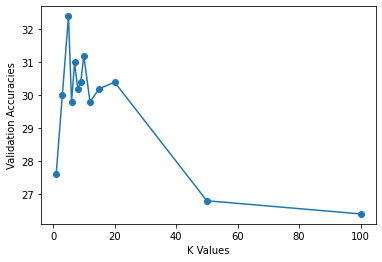

In [198]:
plt.plot(k_choices, 100*k_accuracies, 'o-')
plt.xlabel('K Values')
plt.ylabel('Validation Accuracies')

### **TODO**: Report best k and its accuracy
Report the best validation accuracy and the corresponding k value in this cell below:


When k=5, accuracy = 0.324

Use the best k value you found from the validation set to evaluate you final accuracy on the test set

In [199]:
# Set the value of best_k to be equal to the 'k' which gave the best accuracy
# for the validation set.

best_k = 5
classifier = KNearestNeighbor()
classifier.train(knn_data_dict['X_train'], knn_data_dict['y_train'])
dists = classifier.compute_distances_no_loops(knn_data_dict['X_test'])
y_test_pred, k_idxs  = classifier.predict_labels(dists, k=best_k)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))




Got 162 / 500 correct => accuracy: 0.324000


### Visualize KNN results

Let's visualize the K nearest images for some randomly selected examples from the test set using the k_idxs list you returned in predict_labels 

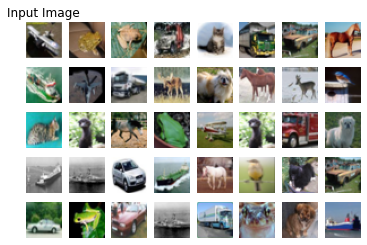

In [220]:
def visualize_knn(num_examples, K):

  idxs = np.random.choice(500, num_examples)
  vis_im = knn_data_dict['X_test'][idxs]
  _, k_idxs = classifier.predict_labels(dists, k=K)
  vis_labels = np.stack(k_idxs, axis=0)[idxs].astype('uint8')
  # (num_examples, K)
  num_images = num_examples*K + num_examples
  for i in range(num_images):
    plt.subplot(num_examples,K+1,i+1)
    if(i%(K+1) == 0):
      plt.imshow(vis_im[int(i/(K+1))].reshape(32,32,3).astype('uint8'))
      plt.axis('off')
      if(i==0): 
        plt.title('Input Image')
    else:
      plt.imshow(knn_data_dict['X_train'][vis_labels[int(i/(K+1)), i - (K+1)*int(i/(K+1)) - 1]].reshape(32,32,3).astype('uint8'))
      plt.axis('off')


# Here the leftmost column is the input image from the test set and rest of the
# K columns are the K nearest neighbors from the training set
num_examples = 5
K = 7
visualize_knn(num_examples, K) 

### *(Optional)* Does normalizing the images give better accuracy?

We normalize each image here by subtracting the image by its mean and dividing by its standard deviation.

In [201]:
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X_instance_mean = np.mean(X_train, axis = (1, 2, 3))
X_instance_std = np.std(X_train, axis = (1, 2, 3))
X_test_instance_mean = np.mean(X_test, axis = (1, 2, 3))
X_test_instance_std = np.std(X_test, axis = (1, 2, 3))
X_train_instance = (X_train - X_instance_mean[:, None, None, None])/X_instance_std[:, None, None, None]
X_test_instance = (X_test - X_test_instance_mean[:, None, None, None])/X_test_instance_std[:, None, None, None]

Store these tensors into a dictionary ``` knn_norm_data_dict ```





In [202]:
knn_norm_data_dict = {}

knn_norm_data_dict['X_train'] = X_train_instance[:knn_num_train].reshape(knn_num_train, -1)
knn_norm_data_dict['y_train'] = y_train[:knn_num_train]
knn_norm_data_dict['X_val'] = X_train_instance[knn_num_train:knn_num_train+knn_num_val].reshape(knn_num_val, -1)
knn_norm_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]
knn_norm_data_dict['X_test'] = X_test_instance[:knn_num_test].reshape(knn_num_test, -1)
knn_norm_data_dict['y_test'] = y_test[:knn_num_test]


print('Train data shape: ', knn_norm_data_dict['X_train'].shape)
print('Train labels shape: ', knn_norm_data_dict['y_train'].shape)
print('Validation data shape: ', knn_norm_data_dict['X_val'].shape)
print('Validation labels shape: ', knn_norm_data_dict['y_val'].shape)
print('Test data shape: ', knn_norm_data_dict['X_test'].shape)
print('Test labels shape: ', knn_norm_data_dict['y_test'].shape)

Train data shape:  (10000, 3072)
Train labels shape:  (10000,)
Validation data shape:  (2000, 3072)
Validation labels shape:  (2000,)
Test data shape:  (500, 3072)
Test labels shape:  (500,)


We calculate the accuracies again using k = 1 and k = 3 and see that the accuracies are much better compared to those we obtained without any preprocessing on the images!

In [203]:
classifier = KNearestNeighbor()
classifier.train(knn_norm_data_dict['X_train'], knn_norm_data_dict['y_train'])

In [204]:
dists = classifier.compute_distances_two_loops(knn_norm_data_dict['X_test'])
y_test_pred, k_labels  = classifier.predict_labels(dists, k=1)

In [205]:
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_norm_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 171 / 500 correct => accuracy: 0.342000


In [206]:
y_test_pred, k_labels = classifier.predict_labels(dists, k=5)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_norm_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 191 / 500 correct => accuracy: 0.382000


## **Problem 3.2** 
Linear classifier with Softmax Loss

### Preprocess images
If we consider N images, we flatten the ``` (N, 32, 32, 3) ``` images into one dimesional arrays of shape ``` (N, 3072) ``` and we append a row of ones for each image, to accomodate for the bias when using the bias trick. This makes the shape of the input images ``` (N, 3073) ```. We also normalize the data by subtracting the mean image from the train and test data.

In [207]:
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

num_training=49000
num_validation=10000
num_test=10000


# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the data: subtract the mean image from train and test data
mean_image = np.mean(X_train, axis=0, keepdims=True)
X_train -= mean_image
X_test -= mean_image

# Append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
ones_train = np.ones((X_train.shape[0],1))
X_train = np.concatenate((X_train, ones_train), axis=1)
ones_test = np.ones((X_test.shape[0],1))
X_test = np.concatenate((X_test, ones_test), axis=1)


# Store them in a dictionary.
data_dict={}
data_dict['X_train'] = X_train[0:num_training]
data_dict['y_train'] = y_train[0:num_training]
data_dict['X_val'] = X_train[num_training:num_training+num_validation]
data_dict['y_val'] = y_train[num_training:num_training+num_validation]
data_dict['X_test'] = X_test[0:num_test]
data_dict['y_test'] = y_test[0:num_test]

print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3073)
Test labels shape:  (10000,)


### (a) Softmax_loss_naive function

In [208]:
def softmax_loss_naive(W, X, y):
  """
  Softmax loss function, naive implementation (with loops)
  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  Returns a tuple of:
  - loss: loss as single float
  - dW: gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  

  num_classes = W.shape[1]
  num_train = X.shape[0]

  # ===== your code here! =====
  
  # TODO: 
  # Calculate the scores and then compute the softmax loss and 
  # its gradient using explicit loops.
  # Store the loss in loss and the gradient in dW. If you are not careful     
  # here, it is easy to run into numeric instability (See Note in the PSet).
  
  for i in range(num_train):
    scores = X[i].dot(W)
    sum_j = 0.0
    sum_2 = 0.0
    max = 0
    for j in range(num_classes):
      sum_j += np.exp(scores[j])
      if (np.exp(scores[j]) > max):
        max = np.exp(scores[j])
    for j in range(num_classes):
      sum_2 += np.exp(scores[j] - max)
    loss += -np.log(np.exp(scores[y[i]] - max)/sum_2) 

    for j in range(num_classes):
      if (j == y[i]):
        dW[:, y[i]] += ((np.exp(scores[y[i]])/ sum_j) - 1) * X[i]
      else:
        dW[:, j] += (np.exp(scores[j]) / sum_j) * X[i]
        
  loss /= num_train
  dW /= num_train
  # ==== end of code ====


  return loss, dW

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix. You should see loss near log(10) = 2.3








In [209]:
# Generate a random weight matrix of small numbers and use it to compute the loss
random.seed(0)
np.random.seed(0)
W = np.random.randn(3073, 10) * 0.00001 

# For debugging purpose we can calculate the loss with very low W and no regularization
# The result should be near log(10) (log(#number_class))
loss, grad = softmax_loss_naive(W, data_dict['X_val'], data_dict['y_val'])
print('loss: %f' % (loss))
print('sanity check: %f' % (np.log(10.0)))

loss: 2.303055
sanity check: 2.302585


To check that you have implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you    

 **(The relative errors should be less than 1e-6)**.


In [210]:
# Compute the loss and its gradient at W. 
loss, grad = softmax_loss_naive(W, data_dict['X_val'], data_dict['y_val'])

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: softmax_loss_naive(w, data_dict['X_val'], data_dict['y_val'])[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 2.584677 analytic: 2.584677, relative error: 2.774534e-08
numerical: 1.951478 analytic: 1.951478, relative error: 1.706606e-08
numerical: -1.353721 analytic: -1.353721, relative error: 1.605797e-08
numerical: 1.205571 analytic: 1.205571, relative error: 4.109712e-08
numerical: 0.063289 analytic: 0.063289, relative error: 8.720625e-07
numerical: -0.523113 analytic: -0.523114, relative error: 5.703314e-08
numerical: -0.289167 analytic: -0.289167, relative error: 9.594850e-08
numerical: 1.047718 analytic: 1.047718, relative error: 6.574467e-08
numerical: -3.473024 analytic: -3.473024, relative error: 6.336547e-09
numerical: -1.130936 analytic: -1.130936, relative error: 1.880963e-08


Next, we implement a vectorized version of the softmax loss for you, for faster execution, as we quantify the speedup in the below cells. In case you want to get a flavor of writing optimized (vectorized) code, it might be helpful to go through this function **after** finishing the required parts of the Problem Set

In [211]:
def softmax_loss_vectorized(W, X, y):
  """
  Softmax loss function, vectorized version.
  Inputs and outputs are the same as softmax_loss_naive.
  """
  
  dW = np.zeros(W.shape) # initialize the gradient as zero
  loss = 0.0             # initialize the loss as zero

  num_train = X.shape[0]
  scores = X.dot(W)
  scores -= np.max(scores, axis =1, keepdims = True)
  exp_scores = np.exp(scores)
  scores_exp_sum = np.sum(exp_scores, axis=1, keepdims=True)
  norm_scores = exp_scores/(scores_exp_sum + 1e-12)
  loss = np.sum(-np.log(norm_scores[range(num_train),y]))

  norm_scores[np.arange(num_train),y] -= 1
  dW = np.matmul(X.T, norm_scores)

  loss/=num_train
  dW/=num_train

  return loss,dW

Now that we have a naive implementation of the softmax loss function and its gradient, we have provided a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be faster.

In [212]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, data_dict['X_val'], data_dict['y_val'])
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, data_dict['X_val'], data_dict['y_val'])
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vectorized, ms_vec))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)
print('Speedup: %f' %(ms_naive/ms_vec))

naive loss: 2.303055e+00 computed in 396.453381s
vectorized loss: 2.303055e+00 computed in 17.717361s
Loss difference: 0.000000
Gradient difference: 0.000000
Speedup: 22.376548


### (b) Define Linear Classifier class

In [213]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y,  X_val, y_val, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.
    Outputs:
    A list containing the value of the loss function at each training iteration.
    """

    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.000001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      # ==== your code here ! ====
      
      # TODO:                                                             
      # Sample batch_size elements from the training data and their       
      # corresponding labels to use them as arguments for the loss        
      # function. Store the data in X_batch and their corresponding       
      # in y_batch.
      index = np.random.choice(num_train, batch_size)
      X_batch = X[index]
      y_batch = y[index]
      # Hint: Use np.random.choice to generate indices. Sampling with
      # replacement is faster than sampling without replacement.      

      # ===== end of code =====


      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch)
      loss_history.append(loss)

      # perform parameter update

      # ==== your code here ! ====
      
      # TODO: 
      # Update the weights using the gradient and the learning rate.
      self.W -= grad * learning_rate

      # ===== end of code =====       

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      y_val_pred = self.predict(X_val)
      val_accuracy = np.mean(y_val == y_val_pred)

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    # ==== your code here ! ====
    
    # TODO: 
    # Implement this method and store the predicted labels in y_pred.
    y_pred = np.argmax(X.dot(self.W), axis=1)
    # ===== end of code =====
    return y_pred

  def loss(self, X_batch, y_batch):
    """
    Compute the loss function and its derivative.
    Subclasses will override this.
    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.
    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass
    
class LinearSoftmax(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch):
    return softmax_loss_vectorized(self.W, X_batch, y_batch)

### (c) Train and test the classifier
Run the linear classifier and observe the train, validation and test accuracies and see the visualization of the weights.

In [214]:
softmax = LinearSoftmax()
tic = time.time()
loss_hist = softmax.train(data_dict['X_train'], data_dict['y_train'], learning_rate=1e-7,
                      num_iters=1500, verbose=True, X_val=data_dict['X_val'], y_val=data_dict['y_val'])
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 2.302404
iteration 100 / 1500: loss 2.001393
iteration 200 / 1500: loss 1.971843
iteration 300 / 1500: loss 1.908188
iteration 400 / 1500: loss 1.871189
iteration 500 / 1500: loss 1.855388
iteration 600 / 1500: loss 1.831074
iteration 700 / 1500: loss 1.792770
iteration 800 / 1500: loss 1.792470
iteration 900 / 1500: loss 1.864091
iteration 1000 / 1500: loss 1.730051
iteration 1100 / 1500: loss 1.911876
iteration 1200 / 1500: loss 1.789723
iteration 1300 / 1500: loss 1.805863
iteration 1400 / 1500: loss 1.855482
That took 16.409699s


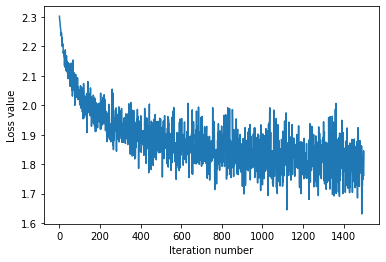

In [215]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [216]:
# Write the LinearSoftmax.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(data_dict['X_train'])
print('training accuracy: %f' % (np.mean(data_dict['y_train'] == y_train_pred), ))
y_val_pred = softmax.predict(data_dict['X_val'])
print('validation accuracy: %f' % (np.mean(data_dict['y_val'] == y_val_pred), ))

training accuracy: 0.387878
validation accuracy: 0.405000


In [217]:
# Evaluate the best softmax on test set
y_test_pred = softmax.predict(data_dict['X_test'])
test_accuracy = np.mean(data_dict['y_test'] == y_test_pred)
print('linear Softmax on raw pixels final test set accuracy: %f' % test_accuracy)

linear Softmax on raw pixels final test set accuracy: 0.384000


 ### Visualize the learned weights for each class.

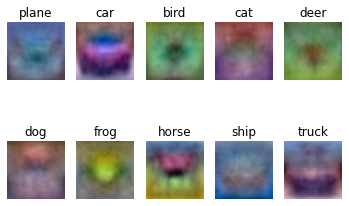

In [218]:
w = softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### (Optional) Interesting patters in the learned weights?
These weights seem to have some interesting pattern, do you see the two headed weight template for the 'horse' class? Any idea why that would happen? Similarly, the template for car has a red car. Any thoughts on why that would happen?

(Cell for optional comment)

Visualize the mean image for each class

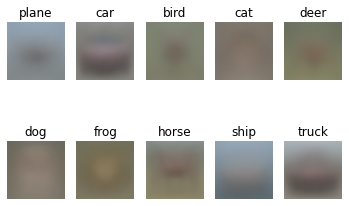

In [219]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 7

for i in range(10):
  plt.subplot(2, 5, i+1)

  idxs = np.flatnonzero(y_train == i)
  mean_img = np.mean(X_train[idxs], axis = 0)
  plt.imshow(mean_img.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])